In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from LDGD.model import ARDRBFKernel, LDGD
from LDGD.model.experimental.GP_scratch import bGPLVM
from LDGD.visualization import plot_box_plots
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.mlls import VariationalELBO
import gpytorch
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import json
import winsound

from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm, plot_box_plots

In [2]:
np.random.seed(42)
torch.manual_seed(42)

duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
def train_model(data_cont, data_cat, settings, filename):
    num_points, data_dim = data_cont.shape
    batch_shape = torch.Size([data_dim])
    settings['use_gpytorch'] = True
    if settings['use_gpytorch'] is False:
        kernel_cls = ARDRBFKernel(input_dim=settings['latent_dim'])
        kernel_reg = ARDRBFKernel(input_dim=settings['latent_dim'])
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()


    if settings['load_model'] is True:
        with open(f'./saved_models/fig3_ldgd_{filename}_settings.json', 'r') as file:
            settings = json.load(file)
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])
        model.load_weights(path_save='./saved_models/', file_name=f"fig3_ldgd_{filename}.pth")
        history_train = model.history_train
        losses = model.history_train['elbo_loss']
    else:
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])

        losses, history_train = model.train_model(yn=data_cont,
                                                  ys=data_cat,
                                                  epochs=settings['num_epochs_train'],
                                                  batch_size=settings['batch_size'])

        if settings['save_model'] is True:
            model.save_wights(path_save='./saved_models/', file_name=f"fig3_ldgd_{filename}")
        with open(f'./saved_models/fig3_ldgd_{filename}_settings.json', 'w') as f:
            json.dump(settings, f)
    return model, losses, history_train, model_settings


# Load Oil dataset

In [29]:
train_data_oil = np.load('../data/train_data.npy', allow_pickle=True)
test_data_oil = np.load('../data/test_data.npy', allow_pickle=True)

yn_train_oil, ys_train_oil, labels_train_oil = train_data_oil.take(0)['yn_train'], train_data_oil.take(0)['ys_train'], train_data_oil.take(0)['labels_train']
yn_test_oil, ys_test_oil, labels_test_oil = test_data_oil.take(0)['yn_test'], test_data_oil.take(0)['ys_test'], test_data_oil.take(0)['labels_test']

yn_train_oil, ys_train_oil, labels_train_oil = torch.Tensor(yn_train_oil), torch.Tensor(ys_train_oil), torch.Tensor(labels_train_oil)
yn_test_oil, ys_test_oil, labels_test_oil = torch.Tensor(yn_test_oil), torch.Tensor(ys_test_oil), torch.Tensor(labels_test_oil)

print(f"Train size : {yn_train_oil.shape[0]} Test size : {yn_test_oil.shape[0]}")

Train size : 800 Test size : 200


# Load IRIS dataset

In [30]:
train_data_iris = np.load('../data/train_data_iris.npy', allow_pickle=True)
test_data_iris = np.load('../data/test_data_iris.npy', allow_pickle=True)

yn_train_iris, ys_train_iris, labels_train_iris = train_data_iris.take(0)['yn_train'], train_data_iris.take(0)['ys_train'], train_data_iris.take(0)['labels_train']
yn_test_iris, ys_test_iris, labels_test_iris = test_data_iris.take(0)['yn_test'], test_data_iris.take(0)['ys_test'], test_data_iris.take(0)['labels_test']

yn_train_iris, ys_train_iris, labels_train_iris = torch.Tensor(yn_train_iris), torch.Tensor(ys_train_iris), torch.Tensor(labels_train_iris)
yn_test_iris, ys_test_iris, labels_test_iris = torch.Tensor(yn_test_iris), torch.Tensor(ys_test_iris), torch.Tensor(labels_test_iris)

print(f"Train size : {yn_train_iris.shape[0]} Test size : {yn_test_iris.shape[0]}")


Train size : 120 Test size : 30


# LDGD
## Oil flow

In [20]:
model_settings = {
    'latent_dim': 7,
    'num_inducing_points_reg': 25,
    'num_inducing_points_cls': 25,
    'num_epochs_train': 25000,
    'num_epochs_test': 25000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'save_model': True,
    'load_model':True,
    'x_init': 'pca',
    'shared_inducing_points': False
}

In [21]:

model_oil, losses_oil, history_train_oil, model_settings = train_model(data_cont = yn_train_oil,
                                                                       data_cat = ys_train_oil,
                                                                       settings = model_settings,
                                                                       filename = 'oil')
winsound.Beep(freq, duration*3)

In [22]:
predictions_oil, metrics_oil, history_test = model_oil.evaluate(yn_test=yn_test_oil, ys_test=labels_test_oil, epochs=5000)

alpha_reg_oil = 1 / model_oil.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_oil = 1 / model_oil.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_oil = model_oil.x.q_mu.cpu().detach().numpy()
std_oil = torch.nn.functional.softplus(model_oil.x.q_log_sigma).cpu().detach().numpy()

x_test_oil = model_oil.x_test.q_mu.cpu().detach().numpy()
std_test_oil = torch.nn.functional.softplus(model_oil.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/5000, Loss: 2146.861328125
Epoch 11/5000, Loss: 1922.9266357421875
Epoch 21/5000, Loss: 2231.06982421875
Epoch 31/5000, Loss: 2054.950927734375
Epoch 41/5000, Loss: 1804.6890869140625
Epoch 51/5000, Loss: 1798.2222900390625
Epoch 61/5000, Loss: 1530.585205078125
Epoch 71/5000, Loss: 1774.70458984375
Epoch 81/5000, Loss: 1534.69189453125
Epoch 91/5000, Loss: 1356.9404296875
Epoch 101/5000, Loss: 1378.134033203125
Epoch 111/5000, Loss: 1334.25
Epoch 121/5000, Loss: 1273.8837890625
Epoch 131/5000, Loss: 1190.71484375
Epoch 141/5000, Loss: 1058.1376953125
Epoch 151/5000, Loss: 1037.2418212890625
Epoch 161/5000, Loss: 909.6229858398438
Epoch 171/5000, Loss: 909.7416381835938
Epoch 181/5000, Loss: 912.15380859375
Epoch 191/5000, Loss: 887.8711547851562
Epoch 201/5000, Loss: 848.7808227539062
Epoch 211/5000, Loss: 743.3712768554688
Epoch 221/5000, Loss: 735.8323974609375
Epoch 231/5000, Loss: 698.0321655273438
Epoch 241/5000, Loss: 622.4169311523438
Epoch 251/5000, Loss: 632.740844726

In [ ]:
latent_dim = x_oil.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_oil, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_oil, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_oil, ax=axs[1])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
plot_scatter_gplvm(x_test_oil, labels_test_oil, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_oil)
plt.tight_layout()


# Iris

In [31]:
model_settings = {
    'latent_dim': 7,
    'num_inducing_points_reg': 5,
    'num_inducing_points_cls': 5,
    'num_epochs_train': 25000,
    'num_epochs_test': 25000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'save_model': True,
    'load_model':False,
    'x_init': None,
    'shared_inducing_points': True
}

model_iris, losses_iris, history_train_iris, model_settings = train_model(data_cont = yn_train_iris,
                                                                          data_cat = ys_train_iris,
                                                                          settings = model_settings,
                                                                          filename = 'iris')
winsound.Beep(freq, duration*2)

Epoch 1/25000, Loss: 54.54587936401367
Epoch 11/25000, Loss: 50.77622604370117
Epoch 21/25000, Loss: 48.74943923950195
Epoch 31/25000, Loss: 45.26705551147461
Epoch 41/25000, Loss: 42.80048751831055
Epoch 51/25000, Loss: 38.59867858886719
Epoch 61/25000, Loss: 37.43105697631836
Epoch 71/25000, Loss: 33.582515716552734
Epoch 81/25000, Loss: 29.554973602294922
Epoch 91/25000, Loss: 26.965442657470703
Epoch 101/25000, Loss: 22.698076248168945
Epoch 111/25000, Loss: 18.936969757080078
Epoch 121/25000, Loss: 16.162303924560547
Epoch 131/25000, Loss: 13.992301940917969
Epoch 141/25000, Loss: 11.995023727416992
Epoch 151/25000, Loss: 10.84628963470459


KeyboardInterrupt: 

In [ ]:
predictions_iris, metrics_iris, history_test = model_iris.evaluate(yn_test=yn_test_iris, ys_test=labels_test_iris, epochs=50)

alpha_reg_iris = 1 / model_iris.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_iris = 1 / model_iris.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_iris = model_iris.x.q_mu.cpu().detach().numpy()
std_iris = torch.nn.functional.softplus(model_iris.x.q_log_sigma).cpu().detach().numpy()

x_test_iris = model_iris.x_test.q_mu.cpu().detach().numpy()
std_test_iris = torch.nn.functional.softplus(model_iris.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

In [ ]:
latent_dim = x_iris.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_iris, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_iris, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_iris, ax=axs[1])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
plot_scatter_gplvm(x_test_iris, labels_test_iris, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_iris)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(32, 8))

values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

plot_ARD_gplvm(x_iris.shape[-1], alpha_cls_iris, ax=axs[0])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[1], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)

values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

plot_ARD_gplvm(x_oil.shape[-1], alpha_cls_oil, ax=axs[2])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)


# Reconstruction

In [32]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points_reg': 30,
    'num_inducing_points_cls': 30,
    'num_epochs_train': 5000,
    'num_epochs_test': 5000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'n_features': 10,
    'save_model': True,
    'load_model':False,
    'x_init': 'pca',
    'shared_inducing_points': False
}

In [33]:
model_oil, losses_oil, history_train_oil, model_settings = train_model(data_cont = yn_train_oil,
                                                                       data_cat = ys_train_oil,
                                                                       settings = model_settings,
                                                                       filename = 'oil_2d')
winsound.Beep(freq, duration*3)

Epoch 1/5000, Loss: 22.336217880249023
Epoch 11/5000, Loss: 18.51838493347168
Epoch 21/5000, Loss: 16.718854904174805
Epoch 31/5000, Loss: 14.954641342163086
Epoch 41/5000, Loss: 14.005221366882324
Epoch 51/5000, Loss: 13.512636184692383
Epoch 61/5000, Loss: 12.383055686950684
Epoch 71/5000, Loss: 11.530489921569824
Epoch 81/5000, Loss: 10.852751731872559
Epoch 91/5000, Loss: 10.39927864074707
Epoch 101/5000, Loss: 9.914107322692871
Epoch 111/5000, Loss: 9.371537208557129
Epoch 121/5000, Loss: 8.983283042907715
Epoch 131/5000, Loss: 8.663666725158691
Epoch 141/5000, Loss: 8.45650863647461
Epoch 151/5000, Loss: 7.331876277923584
Epoch 161/5000, Loss: 7.037354469299316
Epoch 171/5000, Loss: 7.123100280761719
Epoch 181/5000, Loss: 6.630943775177002
Epoch 191/5000, Loss: 6.379542350769043
Epoch 201/5000, Loss: 5.954387664794922
Epoch 211/5000, Loss: 5.532411575317383
Epoch 221/5000, Loss: 5.3967204093933105
Epoch 231/5000, Loss: 4.528028964996338
Epoch 241/5000, Loss: 4.441375255584717
Epo

In [34]:
predictions_oil, metrics_oil, history_test = model_oil.evaluate(yn_test=yn_test_oil, ys_test=labels_test_oil, epochs=5000)

alpha_reg_oil = 1 / model_oil.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_oil = 1 / model_oil.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_oil = model_oil.x.q_mu.cpu().detach().numpy()
std_oil = torch.nn.functional.softplus(model_oil.x.q_log_sigma).cpu().detach().numpy()

x_test_oil = model_iris.x_test.q_mu.cpu().detach().numpy()
std_test_iris = torch.nn.functional.softplus(model_oil.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/5000, Loss: 677.69384765625
Epoch 11/5000, Loss: 628.0534057617188
Epoch 21/5000, Loss: 607.021484375
Epoch 31/5000, Loss: 596.627685546875
Epoch 41/5000, Loss: 572.8756103515625
Epoch 51/5000, Loss: 559.9121704101562
Epoch 61/5000, Loss: 507.024658203125
Epoch 71/5000, Loss: 574.2302856445312
Epoch 81/5000, Loss: 482.24029541015625
Epoch 91/5000, Loss: 463.1412048339844
Epoch 101/5000, Loss: 490.4941711425781
Epoch 111/5000, Loss: 460.3661804199219
Epoch 121/5000, Loss: 488.1919860839844
Epoch 131/5000, Loss: 443.0218811035156
Epoch 141/5000, Loss: 402.0873718261719
Epoch 151/5000, Loss: 398.3838806152344
Epoch 161/5000, Loss: 502.09893798828125
Epoch 171/5000, Loss: 405.7844543457031
Epoch 181/5000, Loss: 371.19268798828125
Epoch 191/5000, Loss: 354.1277770996094
Epoch 201/5000, Loss: 356.77197265625
Epoch 211/5000, Loss: 423.74200439453125
Epoch 221/5000, Loss: 363.0519104003906
Epoch 231/5000, Loss: 395.50201416015625
Epoch 241/5000, Loss: 341.6404113769531
Epoch 251/5000, 

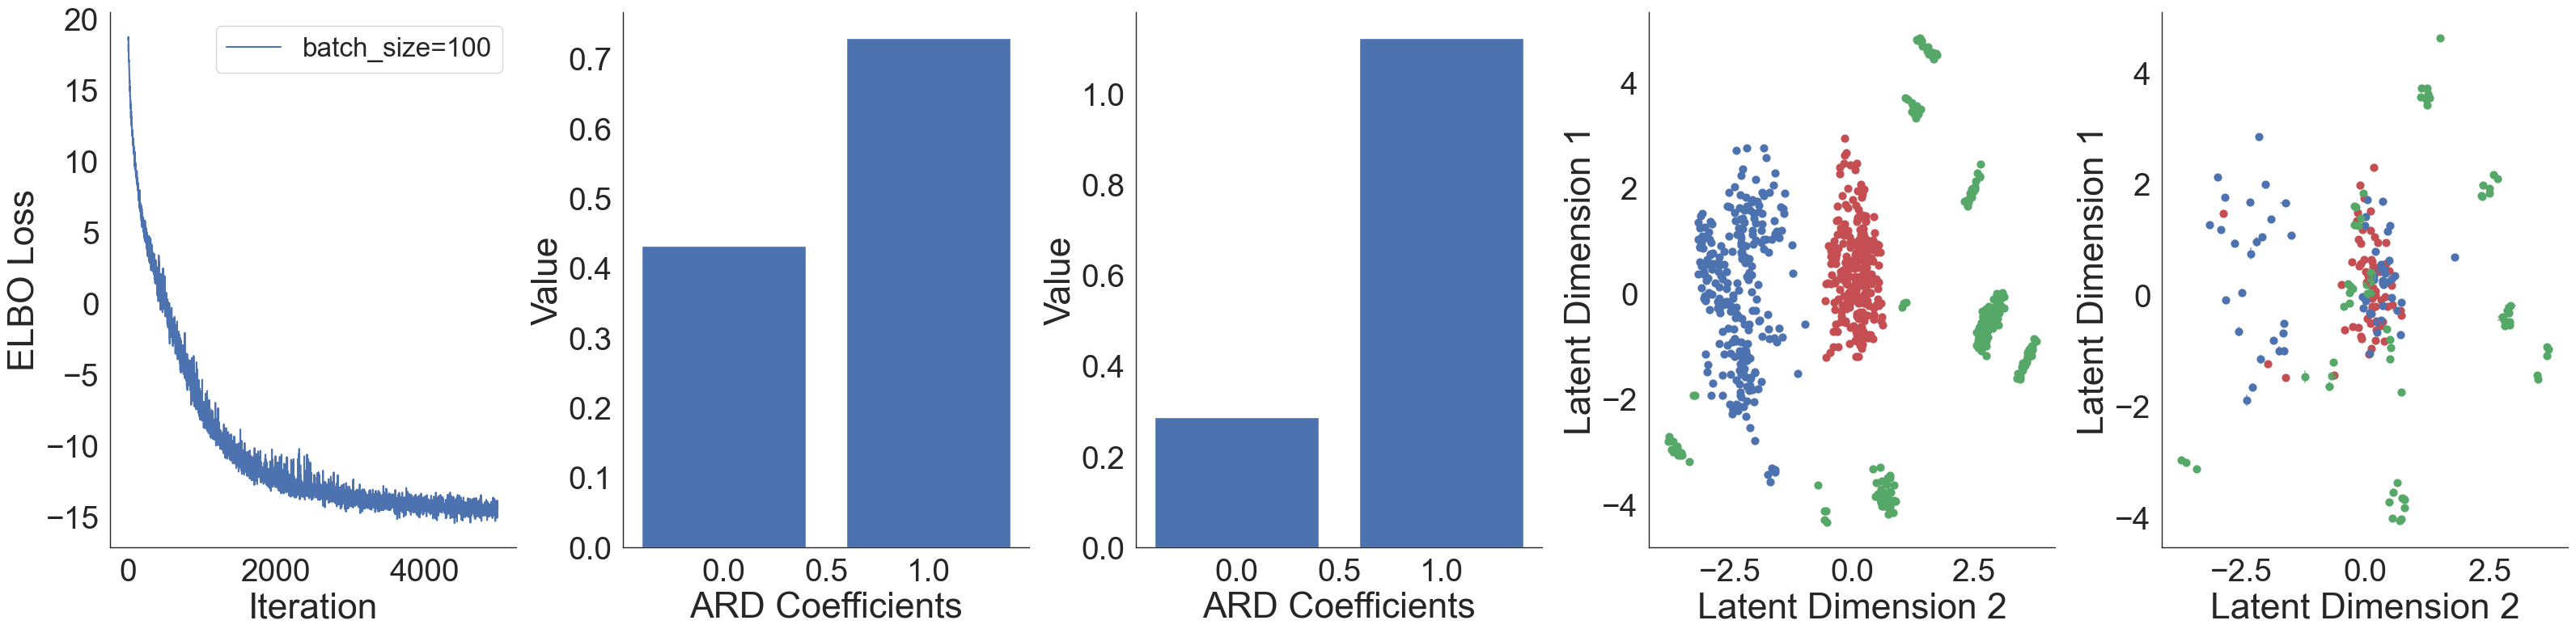

In [35]:
latent_dim = x_oil.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_oil, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_oil, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_oil, ax=axs[1])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
plot_scatter_gplvm(x_test_oil, labels_test_oil, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_oil)
plt.tight_layout()


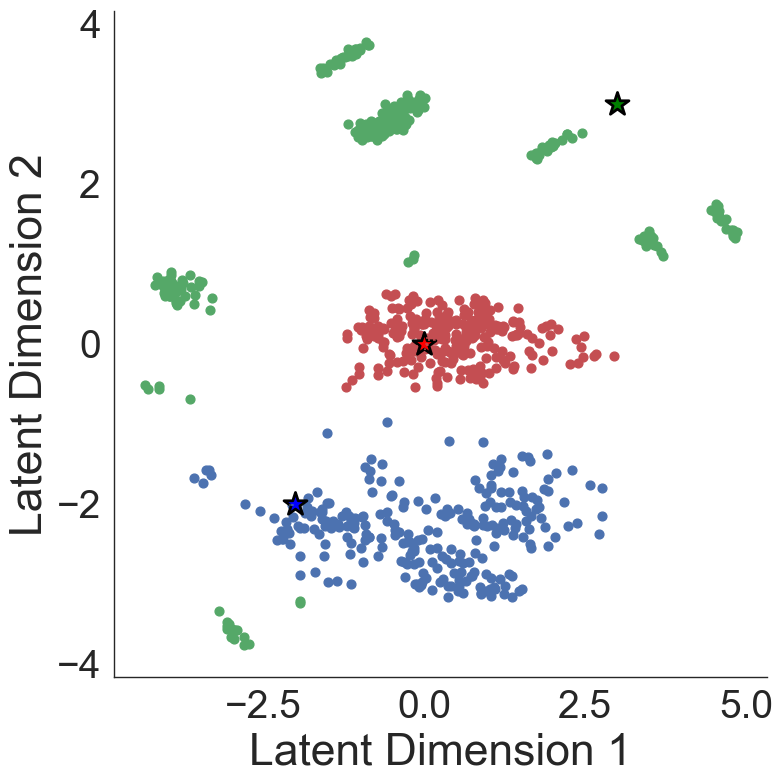

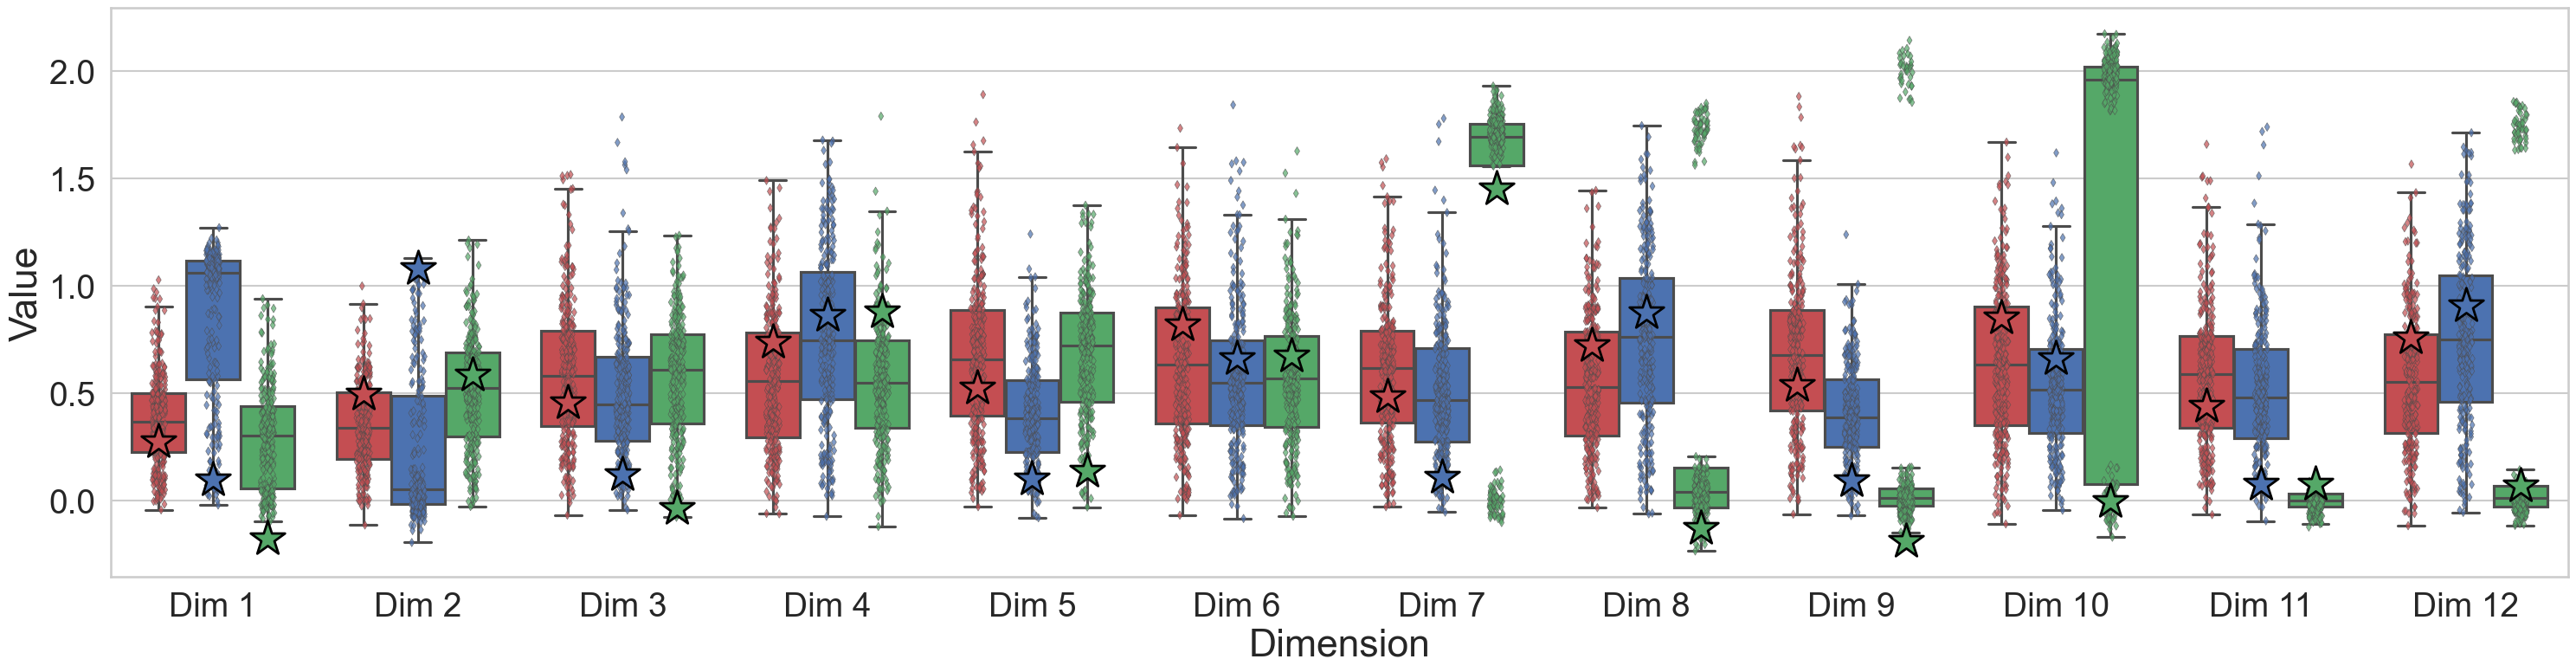

In [90]:
fig, ax = plt.subplots(1, figsize=(8, 8))
test_point = torch.tensor([[3,3], [0, 0], [-2,-2]])

test_point_reconstructed, predictions_std = model_oil.regress_x(test_point)
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=ax, colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
ax.scatter(test_point[0,0], test_point[0,1], marker='*', color='green', s=300, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[1,0], test_point[1,1], marker='*', color='red', s=300, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[2,0], test_point[2,1], marker='*', color='blue', s=300, alpha=1, edgecolor='black', linewidth=2)
plt.tight_layout()
plt.savefig("oil_latent_scatter_with_test_point.png", bbox_inches='tight')
plot_box_plots(data=yn_train_oil, labels=labels_train_oil, save_path='saved_results/', file_name='box_plot_oil_with_point', new_point_values=test_point_reconstructed.cpu().detach(), new_point_label=[2, 0, 1])

plt.tight_layout()
plt.savefig("oil_barplot_with_test_point.png")


In [37]:
x_oil.shape

(800, 2)

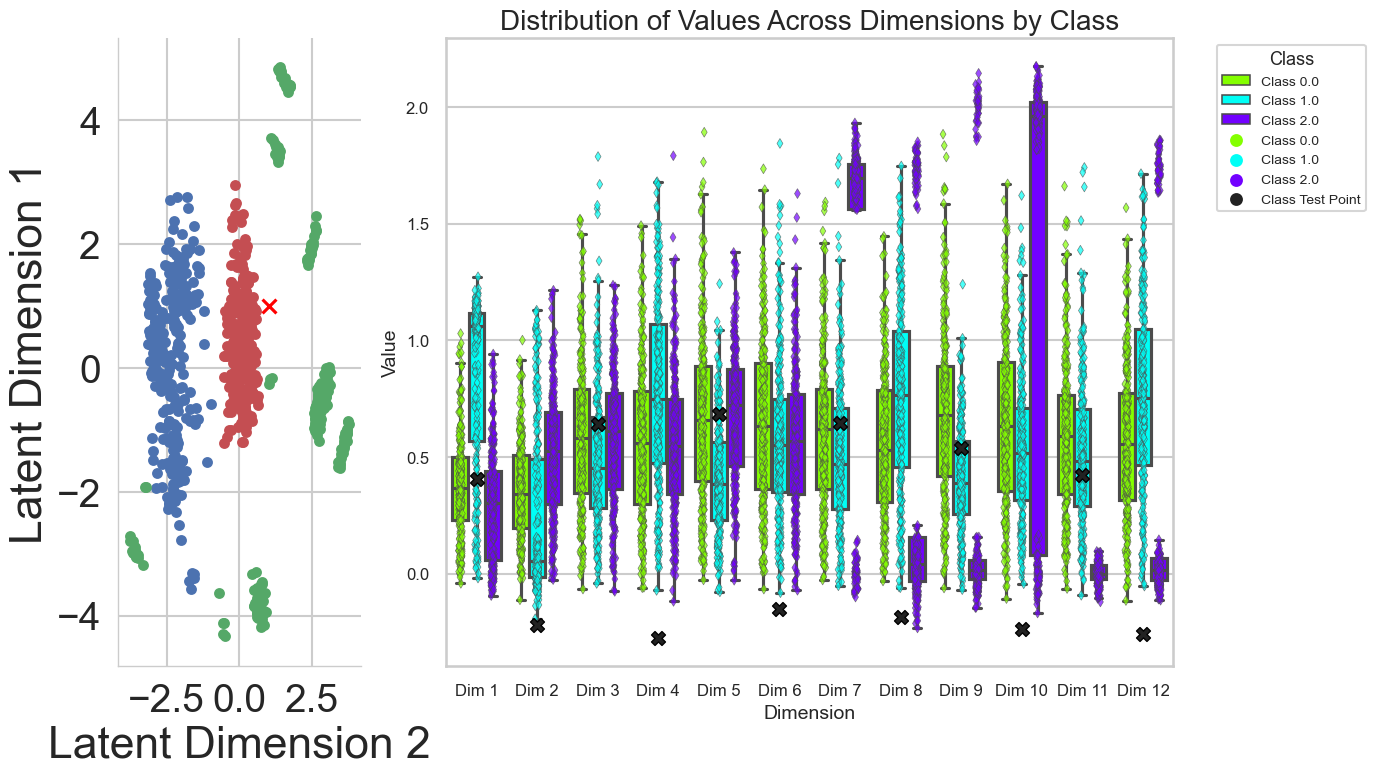

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

fig = plt.figure(figsize=(14, 8))  # Adjust size as needed

# Create a GridSpec with 1 row and 2 columns,
# with the second column taking 75% of the width
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

# Create subplots by specifying their location in the GridSpec
ax1 = fig.add_subplot(gs[0, 0])  # First subplot
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot with more width

# Now, use ax1 and ax2 instead of axs[0] and axs[1]

# Scatter plot on the left
test_point = torch.tensor([[1, 1]])
test_point_reconstructed, predictions_std = model_oil.regress_x(test_point)
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=ax1, colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
ax1.scatter(test_point[0,0], test_point[0,1], marker='x', color='red', s=100)

# Box plot on the right
plot_box_plots(data=yn_train_oil, labels=labels_train_oil, save_path=None, file_name='box_plot_oil', new_point_values=test_point_reconstructed.cpu().detach(), new_point_label=['Test Point'], ax=ax2)

plt.tight_layout()
plt.show()


In [41]:
model_iris, losses_iris, history_train_iris, model_settings = train_model(data_cont = yn_train_iris,
                                                                       data_cat = ys_train_iris,
                                                                       settings = model_settings,
                                                                       filename = 'iris_2d')
winsound.Beep(freq, duration*3)

Epoch 1/5000, Loss: 53.50368881225586
Epoch 11/5000, Loss: 48.62172317504883
Epoch 21/5000, Loss: 42.808109283447266
Epoch 31/5000, Loss: 37.71746826171875
Epoch 41/5000, Loss: 32.0238151550293
Epoch 51/5000, Loss: 27.6011905670166
Epoch 61/5000, Loss: 23.13951301574707
Epoch 71/5000, Loss: 20.253868103027344
Epoch 81/5000, Loss: 15.140344619750977
Epoch 91/5000, Loss: 12.184786796569824
Epoch 101/5000, Loss: 10.130308151245117
Epoch 111/5000, Loss: 8.394901275634766
Epoch 121/5000, Loss: 8.309229850769043
Epoch 131/5000, Loss: 7.355340957641602
Epoch 141/5000, Loss: 6.877115726470947
Epoch 151/5000, Loss: 6.430324077606201
Epoch 161/5000, Loss: 6.604358673095703
Epoch 171/5000, Loss: 6.242333889007568
Epoch 181/5000, Loss: 6.2149248123168945
Epoch 191/5000, Loss: 5.721376419067383
Epoch 201/5000, Loss: 5.810709476470947
Epoch 211/5000, Loss: 5.719598293304443
Epoch 221/5000, Loss: 5.227889537811279
Epoch 231/5000, Loss: 5.165746212005615
Epoch 241/5000, Loss: 4.987296104431152
Epoch 2

In [44]:
predictions_iris, metrics_iris, history_test = model_iris.evaluate(yn_test=yn_test_iris, ys_test=labels_test_iris, epochs=2000)

alpha_reg_iris = 1 / model_iris.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_iris = 1 / model_iris.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_iris = model_iris.x.q_mu.cpu().detach().numpy()
std_iris = torch.nn.functional.softplus(model_iris.x.q_log_sigma).cpu().detach().numpy()

x_test_iris = model_iris.x_test.q_mu.cpu().detach().numpy()
std_test_iris = torch.nn.functional.softplus(model_iris.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/2000, Loss: 1725.050537109375
Epoch 11/2000, Loss: 1720.4178466796875
Epoch 21/2000, Loss: 1362.974853515625
Epoch 31/2000, Loss: 1342.729248046875
Epoch 41/2000, Loss: 1385.446044921875
Epoch 51/2000, Loss: 1369.382568359375
Epoch 61/2000, Loss: 1141.2034912109375
Epoch 71/2000, Loss: 1080.068359375
Epoch 81/2000, Loss: 808.9370727539062
Epoch 91/2000, Loss: 909.3932495117188
Epoch 101/2000, Loss: 883.69140625
Epoch 111/2000, Loss: 879.344482421875
Epoch 121/2000, Loss: 777.4706420898438
Epoch 131/2000, Loss: 607.2987670898438
Epoch 141/2000, Loss: 650.2811279296875
Epoch 151/2000, Loss: 597.3540649414062
Epoch 161/2000, Loss: 324.14862060546875
Epoch 171/2000, Loss: 638.653564453125
Epoch 181/2000, Loss: 299.892333984375
Epoch 191/2000, Loss: 414.6175231933594
Epoch 201/2000, Loss: 263.6472473144531
Epoch 211/2000, Loss: 536.921630859375
Epoch 221/2000, Loss: 347.5838317871094
Epoch 231/2000, Loss: 351.771728515625
Epoch 241/2000, Loss: 398.2172546386719
Epoch 251/2000, Loss:

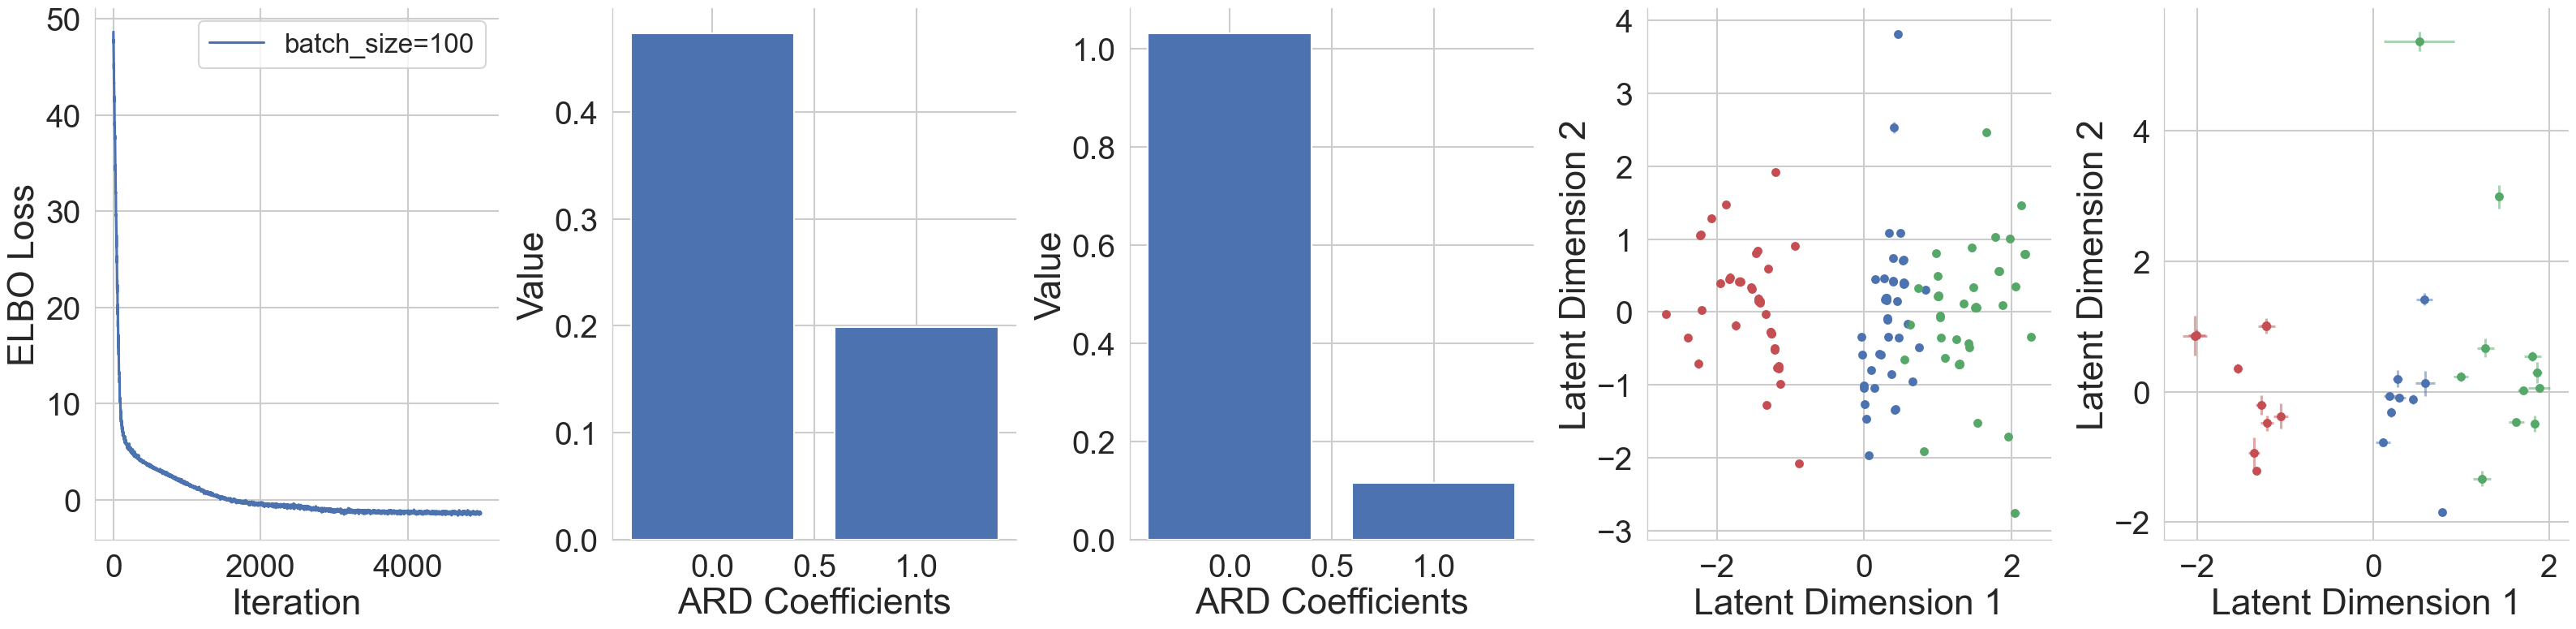

In [96]:
latent_dim = x_iris.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_iris, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_iris, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_iris, ax=axs[1])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
plot_scatter_gplvm(x_test_iris, labels_test_iris, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_iris)
plt.tight_layout()


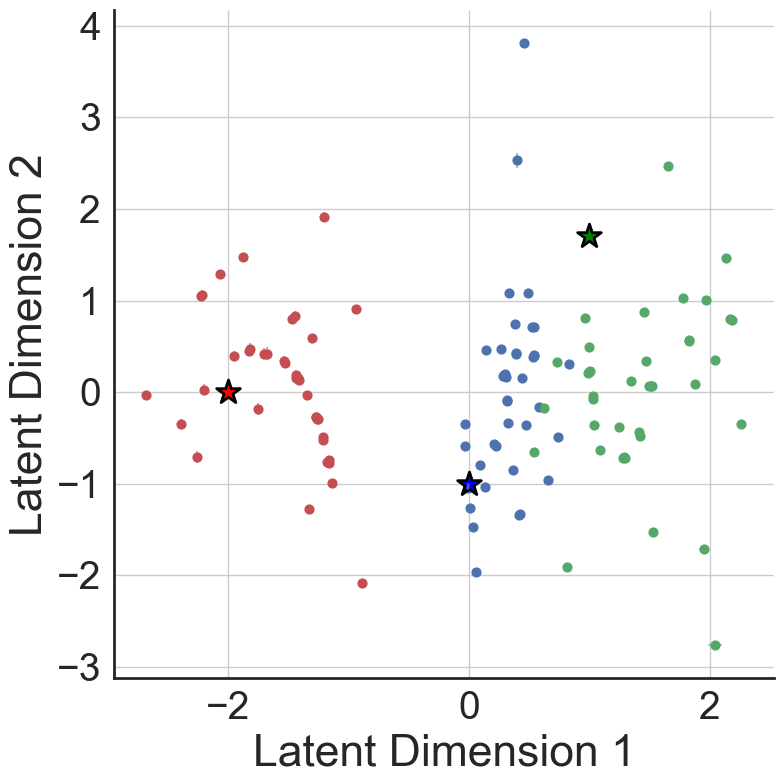

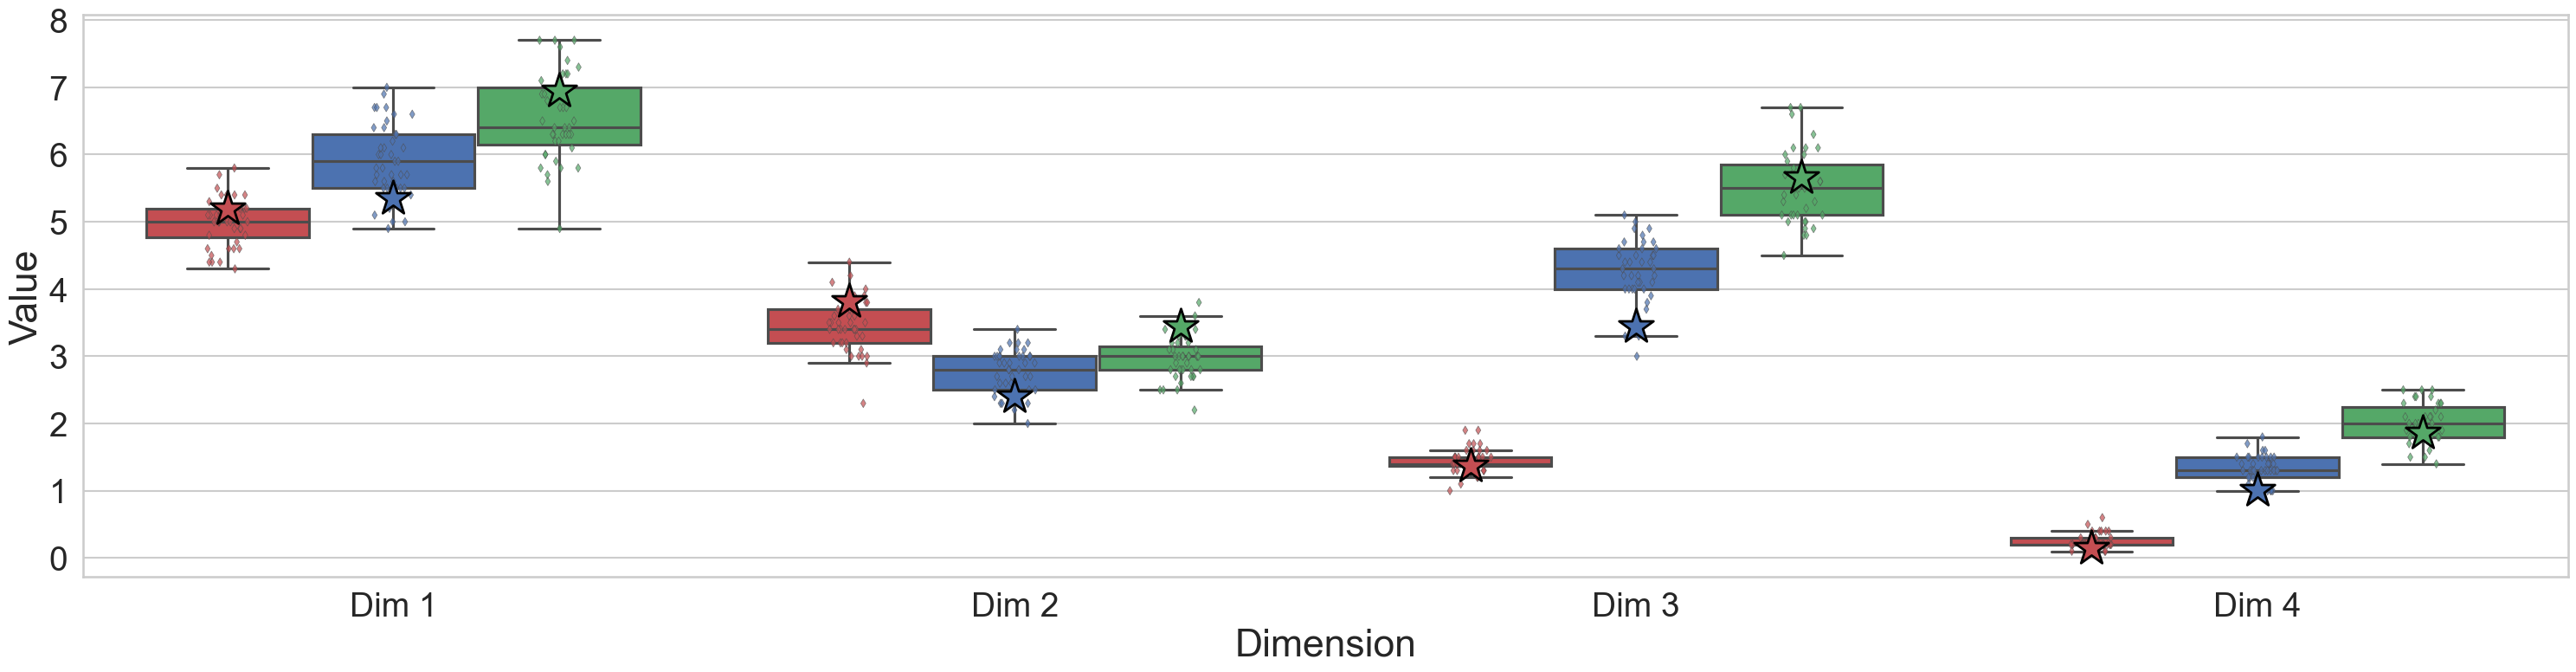

In [98]:
fig, ax = plt.subplots(1, figsize=(8, 8))
test_point = torch.tensor([[1,1.7], [-2, 0], [0,-1]])

test_point_reconstructed, predictions_std = model_iris.regress_x(test_point)
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=ax, colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
ax.scatter(test_point[0,0], test_point[0,1], marker='x', color='green', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[1,0], test_point[1,1], marker='x', color='red', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[2,0], test_point[2,1], marker='x', color='blue', s=400, alpha=1, edgecolor='black', linewidth=2)
plt.grid('off')
plt.tight_layout()
plt.savefig("iris_latent_scatter_with_test_point.png", bbox_inches='tight')
plot_box_plots(data=yn_train_iris, labels=labels_train_iris, save_path='saved_results/', file_name='box_plot_iris_with_point', new_point_values=test_point_reconstructed.cpu().detach(), new_point_label=[2, 0, 1])

plt.tight_layout()
plt.savefig("iris_barplot_with_test_point.png")
plt.savefig("iris_barplot_with_test_point.svg")
